In [4]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score

import plotly.express as px
import TsModel
import GprModel
from sklearn.utils import validation
from windrose import WindroseAxes
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import Circle, RegularPolygon

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Visualization for all models, used in the paper

In [6]:
plt.rcParams.update({'font.size': 18})

In [4]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))
    return model

In [104]:
train_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x.csv', index_col=0).to_numpy()
train_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

test_x = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9x_test.csv', index_col=0).to_numpy()
test_y = pd.read_csv('Data/exp/1102_no_precp_full_dataset/9y_test.csv', index_col=0)['0'].to_numpy().reshape(-1, 1)

In [105]:
input_scaler = StandardScaler()
train_x = input_scaler.fit_transform(train_x)
test_x = input_scaler.transform(test_x)

#train_x, train_y = shuffle(train_x, train_y)
#target_scaler = StandardScaler()

# train_y = target_scaler.fit_transform(train_y)
# test_y = target_scaler.fit_transform(test_y)


In [51]:
train_y.shape

(534300, 1)

In [130]:
linear_model = LinearRegression().fit(train_x, train_y)

In [99]:
gpr_mdoel = GprModel.GprModel()

gpr_mdoel.fit(train_x, train_y)

[2.9842971  1.1304053  0.07198623]


In [100]:
predicted_means,_ = gpr_mdoel.predict(test_x, test_y)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
np.array(predicted_means).ravel().shape

np.concatenate(predicted_means, axis=0).shape

(229000,)

In [75]:
def ground_truth_function_exp1(x):
    
    z = 2*np.sin(x*np.pi+np.pi/4)
        
    return z

# Generator for the 1-D input output data

def data_generator(x, ground_truth_function):
    data=[]
    y = ground_truth_function(x)
    for x, y in zip(x, y):
        data.append([x,y])

    return np.array(data)

np.random.seed()
x_values_1 = np.random.uniform(low=0, high=(4), size=100)
x_values_2 = np.random.uniform(low=10, high=(12), size=200)
x_values_3 = np.random.uniform(low=0, high=(20), size=2000)

# Generate input values
# data = np.vstack(
#     [data_generator(x_values_1, ground_truth_function_exp1), 
#     data_generator(x_values_2,ground_truth_function_exp1), 
#     data_generator(x_values_3, ground_truth_function_exp1)]
# )
data = data_generator(x_values_3, ground_truth_function_exp1)

x_values_4 = np.random.normal(loc=10, scale=3, size=2000)
data2 = data_generator(x_values_4, ground_truth_function_exp1)

In [76]:
data2

array([[11.20744835, -1.98215627],
       [ 9.85799936,  0.66563531],
       [11.80856732,  0.36591652],
       ...,
       [10.63991845,  0.67795795],
       [ 5.87813916,  0.78355188],
       [11.55663879, -1.14157095]])

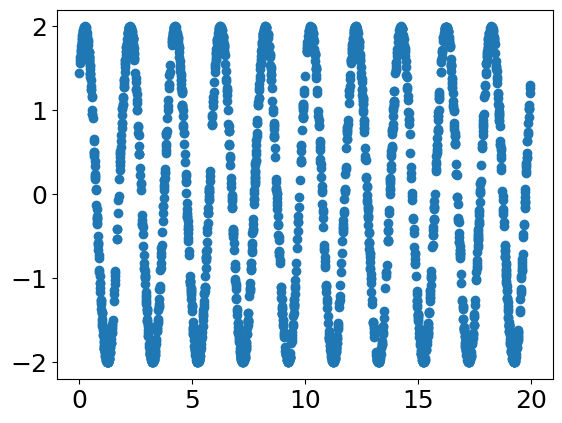

In [66]:
plt.scatter(data[0:,0].reshape(-1,1), data[0:,1].reshape(-1,1))

In [119]:
# Train the TS model
ts_model = TsModel.TsModel(number_of_rules=30, early_end_threshold=1e-8, use_target_in_fcm=False)
ts_model.fit(train_x, train_y)

FCM training RMSE: 6.451955373799188


(41.62772814549622, 6.451955373799188, 68.55360627174377)

In [107]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [120]:
ts_prototypes = ts_model.cen
ts_qs = ts_model.qs
ts_weights = ts_model.W

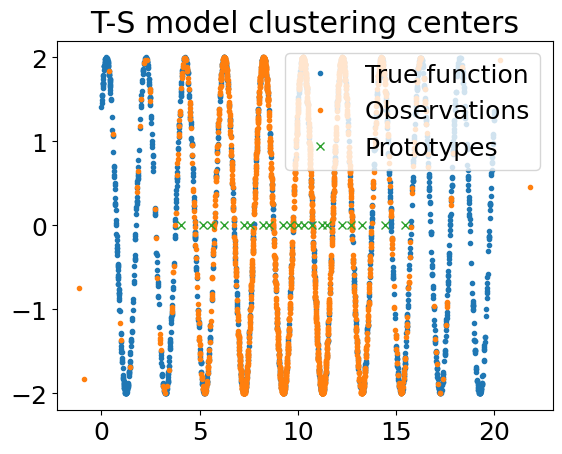

In [82]:
plt.title('T-S model clustering centers')
plt.plot(data[0:,0].reshape(-1,1), data[0:,1].reshape(-1,1),'.', label='True function')
plt.plot(data2[0:,0].reshape(-1,1), data2[0:,1].reshape(-1,1),'.', label='Observations')

plt.plot(ts_prototypes, [0]*len(ts_prototypes), 'x', label='Prototypes')
plt.legend(loc="upper right")

In [122]:
ts_weights = ts_weights.reshape(30,55)

In [123]:
ts_prototypes = np.hstack((ts_prototypes, np.zeros((ts_prototypes.shape[0], 1))))

Text(0.5, 0, 'Iterations')

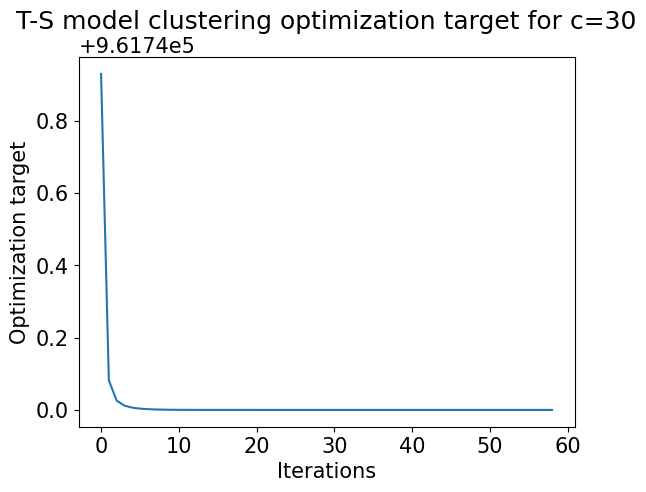

In [129]:
plt.title('T-S model clustering optimization target for c=30')
plt.plot(ts_model.qs)
plt.ylabel('Optimization target')
plt.xlabel('Iterations')

In [124]:
radar_data=[
    [
        'Long1', 'Lat1', 'Temp1', 'Dir1', 'Speed1', 'Dist1',
        'Long2', 'Lat2', 'Temp2', 'Dir2', 'Speed2', 'Dist2',
        'Long3', 'Lat3', 'Temp3', 'Dir3', 'Speed3', 'Dist3',
        'Long4', 'Lat4', 'Temp4', 'Dir4', 'Speed4', 'Dist4',
        'Long5', 'Lat5', 'Temp5', 'Dir5', 'Speed5', 'Dist5',
        'Long6', 'Lat6', 'Temp6', 'Dir6', 'Speed6', 'Dist6',
        'Long7', 'Lat7', 'Temp7', 'Dir7', 'Speed7', 'Dist7',
        'Long8', 'Lat8', 'Temp8', 'Dir8', 'Speed8', 'Dist8',
        'Long9', 'Lat9', 'Temp9', 'Dir9', 'Speed9', 'Dist9','Bias',
    ],
    ('Prototypes',ts_prototypes),
    ('Conclusion parameters',ts_weights)
]

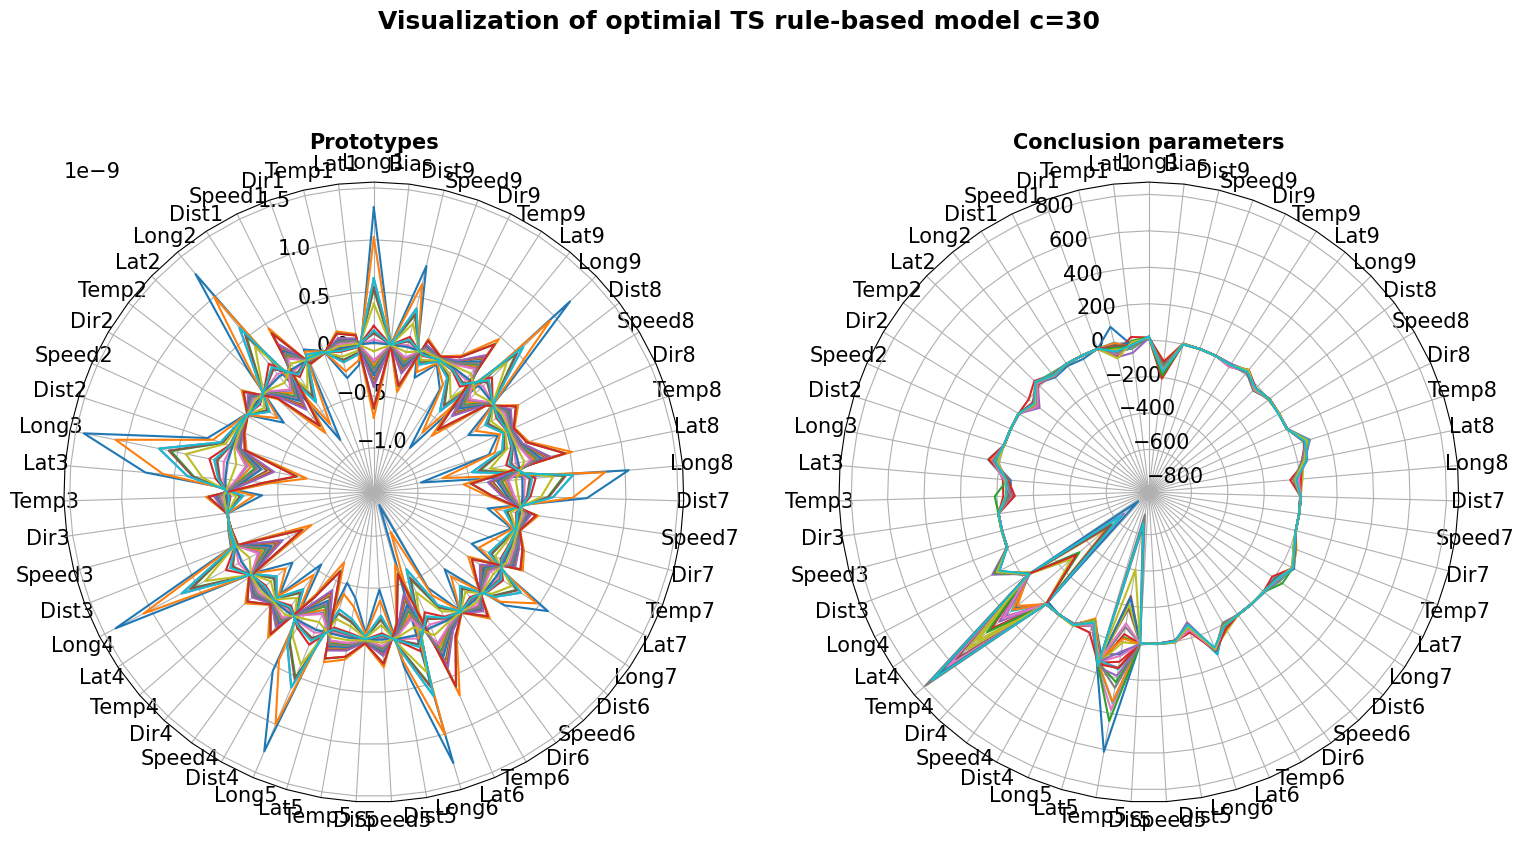

In [125]:
plt.rcParams.update({'font.size': 15})
N = 55
theta = radar_factory(N, frame='polygon')

data = radar_data
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(18, 9), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d in case_data:
        ax.plot(theta, d)
        #ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
# labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
# legend = axs.legend(labels, loc=(0.9, .95),
#                           labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Visualization of optimial TS rule-based model c=30',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()